In [1]:
%matplotlib inline

In [2]:
def get_model_results(history):
    from matplotlib import pyplot as plt
    acc = history.history['mean_absolute_error']
    val_acc = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = [i for i in range(1,len(loss)+1)]
    print(('mae = %0.2f, loss = %0.2f ')%(max(acc),min(loss)))
    print(('val_mae = %0.2f, val_loss = %0.2f ')%(max(acc),min(val_loss)))
    
    plt.figure()
    plt.plot(epochs,acc,'bo',label = 'Training acc')
    plt.plot(epochs,val_acc,'b',label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs,loss,'bo',label = 'Training loss')
    plt.plot(epochs,val_loss,'b',label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [150]:
def get_model_results_acc(history):
    from matplotlib import pyplot as plt
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = [i for i in range(1,len(loss)+1)]
    print(('mae = %0.2f, loss = %0.2f ')%(max(acc),min(loss)))
    print(('val_mae = %0.2f, val_loss = %0.2f ')%(max(acc),min(val_loss)))
    
    plt.figure()
    plt.plot(epochs,acc,'bo',label = 'Training acc')
    plt.plot(epochs,val_acc,'b',label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs,loss,'bo',label = 'Training loss')
    plt.plot(epochs,val_loss,'b',label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [4]:
from pandas import read_csv
from keras.models import Model
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from numpy import random

In [5]:
data = read_csv('../datasets/BostonHousing.csv')

In [6]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### Attributes

>CRIM: per capita crime rate by town.
>
>ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
>
>INDUS: proportion of non-retail business acres per town.
>
>CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
>
>NOX: nitric oxides concentration (parts per 10 million).
>
>RM: average number of rooms per dwelling.
>
>AGE: proportion of owner-occupied units built prior to 1940.
>
>DIS: weighted distances to ﬁve Boston employment centers.
>
>RAD: index of accessibility to radial highways.
>
>TAX: full-value property-tax rate per 10,000 dollars.
>
>PTRATIO: pupil-teacher ratio by town.
>
>B: 1000(Bk−0.63)^2 where Bk is the proportion of blacks by town.
>
>LSTAT: Percent lower status of the population.
>
>MEDV: Median value of owner-occupied homes in thousand dollars.

### Model definition using a function

In [7]:
def build_nn_model(optimizer=Adam(lr=0.0001), init='normal'):
    input_data = layers.Input(shape=(13,))
    x = layers.Dense(9,kernel_initializer=init,activation = 'relu')(input_data)
    x = layers.Dense(5,kernel_initializer=init,activation = 'relu')(x)
    x = layers.Dense(1,kernel_initializer=init)(x)
    model_mlp = Model(input_data,x)
    model_mlp.compile(optimizer=optimizer, loss = 'mse', metrics = ['mae'])
    return(model_mlp)

### Running the model using a usual validation split

In [8]:
model = build_nn_model()
X = data.values[:,:-1]
Y = data.values[:,-1]
history = model.fit(X,
                    Y,
                    epochs=100,
                    batch_size=1,
                    validation_split=0.1,
                    verbose=False)

mae = 20.92, loss = 44.11 
val_mae = 20.92, val_loss = 19.57 


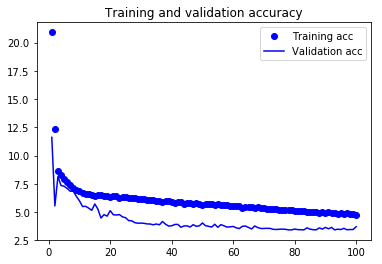

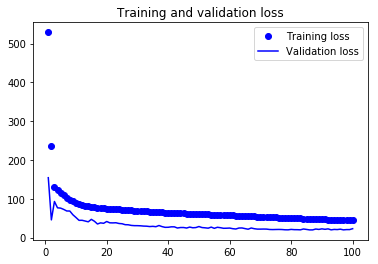

In [9]:
get_model_results(history)
#batch_size = 1
#mae = 9.37, loss = 16.68 
#val_mae = 9.37, val_loss = 18.56

mae = 0.84, loss = 0.13 
val_mae = 0.84, val_loss = 0.10 


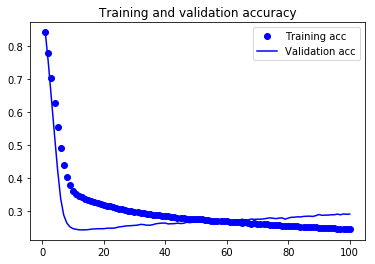

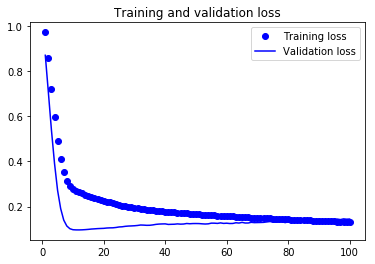

In [10]:
## Standardarize the data
X = data.values[:,:-1]
Y = data.values[:,-1]

X -= X.mean(axis = 0)
X /= X.std(axis = 0)
Y -= Y.mean(axis = 0)
Y /= Y.std(axis = 0)

history = model.fit(X,
                    Y,
                    epochs=100,
                    batch_size=1,
                    validation_split=0.1,
                    verbose=False)

get_model_results(history)

### Pipeline definition

In [68]:
seed = 1234
random.seed(seed)
kfold = KFold(n_splits=10, random_state=seed)
X = data.values[:,:-1]
Y = data.values[:,-1]

estimators = []
estimators.append(('standarize',StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=build_nn_model, epochs=100, batch_size=1, verbose=0)))

pipeline = Pipeline(estimators)

### Using Cross-Validation

In [72]:
results = cross_val_score(pipeline, X, Y, cv=kfold)

In [73]:
print("MSE: %.2f (%.2f) MSE" % (results.mean(), results.std()))

MSE: -47.71 (43.24) MSE


In [74]:
# Fit the pipeline
pipeline.fit(X, Y)

# Pipeline test accuracy
print('Test accuracy: %.3f' % pipeline.score(X, Y))

Test accuracy: -33.073


In [78]:
print('\nModel hyperparameters:\n', pipeline.steps[1][1].get_params())


Model hyperparameters:
 {'epochs': 10, 'batch_size': 5, 'verbose': 0, 'build_fn': <function build_nn_model at 0x7f1760127950>}


## Hyperparameter search / Grid Search

### GridSearch for a pipeline model

In [155]:
def build_nn_model(optimizer='adam', init='normal'):
    input_data = layers.Input(shape=(13,))
    x = layers.Dense(9,kernel_initializer=init,activation = 'relu')(input_data)
    x = layers.Dense(5,kernel_initializer=init,activation = 'relu')(x)
    x = layers.Dense(1,kernel_initializer=init)(x)
    model_mlp = Model(input_data,x)
    model_mlp.compile(optimizer=optimizer, loss = 'mse', metrics = ['mae'])
    return(model_mlp)

seed = 1234
random.seed(seed)
X = data.values[:,:-1]
Y = data.values[:,-1]
estimators = [('standarize',StandardScaler()),
              ('mlp', KerasRegressor(build_fn=build_nn_model,verbose=0))]##epochs=10, batch_size=5, 
pipeline = Pipeline(estimators)
param_grid = [{'mlp__optimizer':['adam'], #'rmsprop',
               'mlp__init' : ['normal', 'uniform'], # 'glorot_uniform',
               'mlp__epochs' : [100],
               'mlp__batch_size' : [1, 20]}]

In [156]:
# Construct grid search
gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=10)

# Fit using grid search
gs.fit(X, Y)

# Best accuracy
print('Best accuracy: %.3f' % gs.best_score_)

# Best params
print('\nBest params:\n', gs.best_params_)

Best accuracy: -21.767

Best params:
 {'mlp__batch_size': 1, 'mlp__epochs': 100, 'mlp__init': 'normal', 'mlp__optimizer': 'adam'}


In [159]:
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
#for mean, stdev, param in zip(gs.cv_results_['mean_test_score'],
#                              gs.cv_results_['std_test_score'],
#                              gs.cv_results_['params']):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -21.767004 using {'mlp__batch_size': 1, 'mlp__epochs': 100, 'mlp__init': 'normal', 'mlp__optimizer': 'adam'}


### GridSearch for a stand-alone model - outside of a pipeline -

In [142]:
# Model from keras
model = KerasRegressor(build_fn=build_nn_model, verbose=0)

# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)

In [ ]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring = 'neg_mean_squared_error',
                    cv = 10)
grid_result = grid.fit(X, Y)

In [157]:
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
#for mean, stdev, param in zip(gs.cv_results_['mean_test_score'],
#                              gs.cv_results_['std_test_score'],
#                              gs.cv_results_['params']):
#    print("%f (%f) with: %r" % (mean, stdev, param))
## Best: -59.377167 using {'batch_size': 20, 'epochs': 100, 'init': 'normal', 'optimizer': 'adam'}

Best: -21.767004 using {'mlp__batch_size': 1, 'mlp__epochs': 100, 'mlp__init': 'normal', 'mlp__optimizer': 'adam'}


### Model Ensemble 

In [258]:
from mnist import MNIST

mndata = MNIST('../datasets/mnist/')
images, labels = mndata.load_training()
images_test, labels_test = mndata.load_testing()

In [112]:
print(len(images),len(images[0]),28*28)
imglen = len(images[0])

60000 784 784


In [278]:
from keras.utils import to_categorical

imgdata = asarray(images)
imglabel= to_categorical(asarray(labels),10)
imgdata = imgdata / imgdata.max()

imgdata_test = asarray(images_test)
imglabel_test= to_categorical(asarray(labels_test),10)
imgdata_test = imgdata_test / imgdata.max()

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [255]:
## Here I have to start an example with classification instead that a regression.


def build_nn_model(optimizer='adam', init='normal'):
    input_data = layers.Input(shape=(13,))
    x = layers.Dense(9,kernel_initializer=init,activation = 'relu')(input_data)
    x = layers.Dense(5,kernel_initializer=init,activation = 'relu')(x)
    x = layers.Dense(1,kernel_initializer=init)(x)
    model_mlp = Model(input_data,x)
    model_mlp.compile(optimizer=optimizer, loss = 'mse', metrics = ['mae'])
    return(model_mlp)


def buil_lstm_model():
    input_data = layers.Input(shape=(maxlen,))
    x = layers.Embedding(embedding_matrix.shape[0],
                         embedding_matrix.shape[1],
                         input_length=maxlen,
                         trainable = False,
                         weights = [embedding_matrix],
                         mask_zero = True)(input_data)
    x = layers.Bidirectional(layers.GRU(32, dropout = 0.1, recurrent_dropout=0.5, return_sequences=False, use_bias=True))(x)
    x = layers.Dense(1,activation='sigmoid', use_bias=True)(x)
    lstm_model = Model(input_data,x)
    lstm_model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
    return(lstm_model)
    

def buil_conv_model2():
    input_data = layers.Input(shape=(784,), name = 'input_1')
    x = layers.Reshape((784, -1), input_shape=(784,))(input_data)
    x = layers.Conv1D(10,
                      kernel_size=(7),
                      activation='relu',
                      input_shape=(28, 28),
                      name='conv_1')(x)
    x = layers.MaxPool1D(5)(x)
    x = layers.Conv1D(10, 3, activation='relu',name='conv_2')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(10, activation='softmax', use_bias=True,name='dense_final')(x)
    conv_model = Model(input_data, x)
    conv_model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
    return(conv_model)



seed = 1234
random.seed(seed)
kfold = KFold(n_splits=10, random_state=seed)
estimators = []

conv = KerasRegressor(build_fn = buil_conv_model, batch_size = 128,epochs=10,verbose=0)
#tree = DecisionTreeClassifier(max_depth=4)
#knn7 = KNeighborsClassifier(n_neighbors=7)
#svm_r = SVC(kernel='rbf', probability=True)
#ensemble = VotingClassifier(estimators=[('tree', tree), ('knn7', knn7),('svc',svm_r)], 
#                            voting='soft', weights=[2,1,2])
ensemble = VotingClassifier(estimators=[('conv_nn', conv)])

### Convolutianal network to solve mnist

In [341]:
def buil_conv_model():
    input_data = layers.Input(shape=(784,), name = 'input_1')
    x = layers.Reshape((28, 28,-1), input_shape=(784,))(input_data)
    x = layers.Conv2D(32,
                      kernel_size=(5,5),
                      input_shape=(28, 28),
                      activation='relu',
                      name='conv_1')(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, kernel_initializer='normal', activation='relu', use_bias=True, name='dense_1')(x)
    x = layers.Dense(10, kernel_initializer='normal', activation='softmax', use_bias=True,name='dense_final')(x)
    conv_model = Model(input_data, x)
    conv_model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
    return(conv_model)


def buil_conv_model2():
    input_data = layers.Input(shape=(784,), name = 'input_1')
    x = layers.Reshape((784, -1), input_shape=(784,))(input_data)
    x = layers.Conv1D(10,
                      kernel_size=(7),
                      activation='relu',
                      input_shape=(28, 28),
                      name='conv_1')(x)
    x = layers.MaxPool1D(5)(x)
    x = layers.Conv1D(10, 3, activation='relu',name='conv_2')(x)
    x = layers.MaxPool1D(5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(10, activation='softmax', use_bias=True,name='dense_final')(x)
    conv_model = Model(input_data, x)
    conv_model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
    return(conv_model)


conv_model = buil_conv_model()
conv_model2 = buil_conv_model2()

In [342]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_58 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
__________

In [343]:
conv_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_59 (Reshape)         (None, 784, 1)            0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 778, 10)           80        
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 155, 10)           0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 153, 10)           310       
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 30, 10)            0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 300)               0         
__________

In [344]:
history = conv_model.fit(imgdata,
                         imglabel,
                         epochs=10,
                         batch_size=128,
                         validation_data=(imgdata_test,imglabel_test),
                         verbose=False)

mae = 1.00, loss = 0.01 
val_mae = 1.00, val_loss = 0.27 


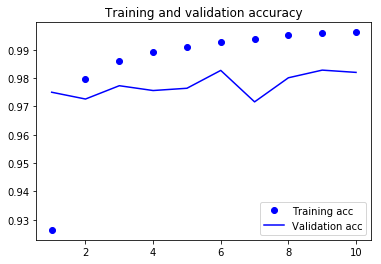

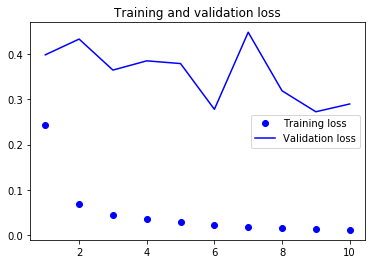

In [331]:
get_model_results_acc(history)

In [84]:
# results #[0.5  , 0.498, 0.488, 0.506, 0.515, 0.533, 0.53 , 0.514, 0.507, 0.514]

In [339]:
history2 = conv_model2.fit(imgdata,
                           imglabel,
                           epochs=10,
                           batch_size=128,
                           validation_data=(imgdata_test,imglabel_test),
                           verbose=False)

mae = 0.94, loss = 0.19 
val_mae = 0.94, val_loss = 1.47 


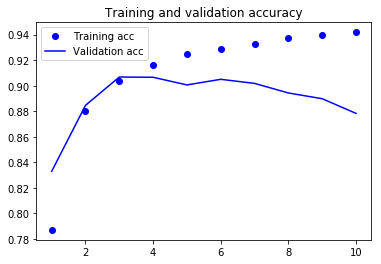

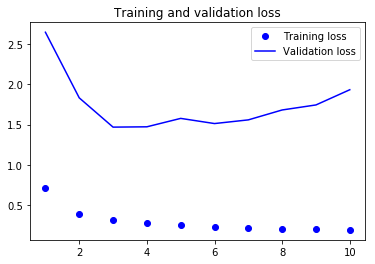

In [345]:
get_model_results_acc(history2)